In [1]:
import os
import numpy as np
#from train_lstm_oh import build_model

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model

from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.recurrent import GRU,LSTM
from keras.layers import Input
from keras.layers.convolutional import ZeroPadding3D, Conv2D
from keras import regularizers
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Dropout, Flatten, Dense, Activation
from keras.optimizers import Adam
from keras import backend as K
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
CURRENT_PATH = os.getcwd()
DATA_PATH = CURRENT_PATH

In [3]:
# load test data
x_path = DATA_PATH + '/X.npz'
y_path = DATA_PATH + '/y.npz'
x_s = np.load(x_path)['x']
y_s = np.load(y_path)['y']
x_train, x_test, y_train, y_test = train_test_split(x_s, y_s, test_size=0.2, shuffle=True)

In [4]:
def build_model(input_size, output_size=28):
    #########################################################
    # Model: conv2d + conv2d + maxpool + dropout + conv2d +
    #  bidirectional gru + dense + softmax + ctc loss
    #########################################################

    ## input_size: placeholder in Keras
    #  shape: (None, seq_size = 20, height = 50, width = 100, channels = 3)
    # if K.image_data_format() == 'channels_first':
    #     input_size = (self.img_c, self.frames_n, self.img_w, self.img_h)
    # else:
    #     input_size = (self.frames_n, self.img_w, self.img_h, self.img_c)

    # self.input_data = Input(name='the_input', shape=input_size, dtype='float32')
    input_data = Input(name='the_input', shape=input_size, dtype='float32')
    
    ## padding used on the height and width before convolving
    #  shape:(None, 20, 54, 104, 3)
    model = Sequential()
    model.add(ZeroPadding3D(padding=(0, 2, 2),input_shape = (input_size), name='padding1'))

    ## 2D Convolution on each time sequence, relu activation
    #  shape 1st conv: (None, 20, 27, 52, 32)
    #  shape 2nd conv: (None, 20, 14, 26, 32)
    model.add(TimeDistributed(Conv2D(filters=34, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max1')))

    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max2')))
    model.add(Dropout(0))

    ## 2D Convolution on each time sequence, relu activation
    #  shape 1st conv: (None, 20, 4, 7, 4)
    model.add(TimeDistributed(Conv2D(filters=96, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(2, 2), padding='same', activation='relu')))

    ## Flatten to gru
    #  shape: (None, 20, 112)
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.0))
    ## Bidirectional gru
    #  shape: (None, 20, 512)
    # x_lstm = LSTM(256, return_sequences=True, kernel_initializer='Orthogonal', name='lstm1')(input_lstm)
    # x_lstm = LSTM(256, return_sequences=True, kernel_initializer='Orthogonal', name='lstm2')(x_lstm)
    model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'),
                           merge_mode='concat'))
    model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2'),
                           merge_mode='concat'))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal', name='fc1', kernel_regularizer=regularizers.l2(0.0)))
    model.add(Dense(output_size, kernel_initializer='he_normal', name='dense2'))

    ## prepare input for ctc loss
    model.add(Activation('softmax', name='softmax'))
    #loss = CTC('ctc', [y_pred, labels, input_length, label_length])
    model.summary()

    return model
def build_model_vgg16(input_size, output_size=28):
    input_data = Input(name='the_input', shape=input_size, dtype='float32')

    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_size[1:], pooling='max')
    x = TimeDistributed(vgg16)(input_data)
    x = TimeDistributed(Flatten())(x)

    # let's add a fully-connected layer
    x = Bidirectional(GRU(256, return_sequences=True, name='gru1'), merge_mode='concat')(x)
    x = Bidirectional(GRU(256, return_sequences=True, name='gru1'), merge_mode='concat')(x)
    x = Flatten()(x)

    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)
    predictions = Dense(output_size, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=input_data, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in vgg16.layers:
       layer.trainable = False
    model.summary()
    return model
def train(model, x_train, y_train, batch_size=256, epochs=100, val_train_ratio=0.2, start_epoch=0):
    ##
    # Train model, typically will train for each speaker
    ## padding the labels
    # max_string_len = 10
    # if y_train.shape[1] != max_string_len:
    #     y_train = pad_labels(y_train, max_string_len)

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    if start_epoch > 0:
        weight_file = os.path.join(CURRENT_PATH, "models/model_lstm_oh.h5")
        model.load_weights(weight_file)
    ## callbacks when each epoch ends
    #  This will ouput character error rate which
    #  compares each predicted word with source word.
    #  TODO: results file need to be implemented
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_train_ratio,
                        shuffle=True,
                        initial_epoch=start_epoch,
                        verbose=1)
    return history

In [5]:
# train model, if there is not a pre trained model
# if already has a model do not train it, this is just for test
# model = build_model_vgg16(x_test.shape[1:], output_size=y_test.shape[1])
# history = train(model, x_train, y_train, batch_size=256, epochs=20,
#                     start_epoch=0)
# model.save('model_lstm_oh.h5')

In [6]:
# change model dir here
model_dir = 'model_vgg16-gru-fc4096-lr0.0001.h5'
model = build_model_vgg16(x_test.shape[1:], output_size=y_test.shape[1])

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
weight_file = os.path.join(CURRENT_PATH, model_dir)
model.load_weights(weight_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 21, 50, 100, 3)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 512)           14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 512)           1181184   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 512)           1181184   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              44044288  
__________

In [90]:
# choose one sample to test
import pickle
with open('le.p', 'rb') as handle:
    le = pickle.load(handle)
ind = 41
preds = model.predict(np.expand_dims(x_test[ind],0))
pred_label = np.argmax(preds)
least_label = np.argmin(preds)
true_label = np.argmax(y_test[ind])
print("true label is: ",true_label, "predict label is :", pred_label )

print("true word is: ", le.inverse_transform(true_label),
      "predict word is:",le.inverse_transform(pred_label) )
# print("probabilities: ",preds)

('true label is: ', 37, 'predict label is :', 37)
('true word is: ', 'seven', 'predict word is:', 'seven')


In [31]:
# check score for baseline
# prepare for integrated gradient
from scipy.ndimage import imread
sil_img = imread('preprocessing/sil_img.png')
sil_img = np.stack([sil_img for _ in range(x_test[ind].shape[0])], axis =0)
# preds = model.predict(np.expand_dims(sil_img,0))
# pred_label = np.argmax(preds)
# least_label = np.argmin(preds)

## This is a visualization for Saliency Map

In [32]:
from keras.preprocessing import image
from matplotlib import pylab as plt
def show_image(image_new, grayscale = True, ax=None, title=''):
    image = image_new.copy()
    title_size = 40
    if ax is None:
        plt.figure()
    plt.axis('off')
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.max(np.abs(image), axis = 2)
        plt.imshow(image, cmap=plt.cm.hot)
        plt.title(title, fontsize = title_size)
    else:
        for i in range(3):
            #image = image + 127.5
            rmax = np.max(sil_img[:,:,i])
            rmin = np.min(sil_img[:,:,i])
            vmax = np.max(image[:,:,i])
            vmin = np.min(image[:,:,i])
            image[:,:,i] = (image[:,:,i] - vmin)*(rmax-rmin)/(vmax-vmin)+rmin
        image = image.astype('uint8')
        plt.imshow(image)
        plt.title(title, fontsize = title_size)
    

In [33]:
# (NOT USING) visualization - Vanilla Saliency Map 
# from vis.saliency import GradientSaliency
# vanilla = GradientSaliency(model,true_label)
# least_vanilla = GradientSaliency(model,least_label)
# mask_saliency = vanilla.get_mask(x_test[ind])
# least_mask_saliency = least_vanilla.get_mask(x_test[ind])

In [48]:
# visualization - guided backpropagation
from vis.guided_backprop import GuidedBackprop
guided_bprop = GuidedBackprop(model,true_label)
least_guided_bprop = GuidedBackprop(model,least_label)
mask = guided_bprop.get_mask(x_test[ind])
least_mask = least_guided_bprop.get_mask(x_test[ind])

In [49]:
# (NOT USING)integrated gradient 
# from vis.integrated_gradients import IntegratedGradients
# inter_grad = IntegratedGradients(model,true_label)
# least_inter_grad = IntegratedGradients(model,least_label)
# mask_integrated = inter_grad.GetMask(x_test[ind], input_baseline = sil_img, nsamples=100)
#least_mask_integrated = least_inter_grad.GetMask(x_test[ind], input_baseline = sil_img, nsamples=100)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide


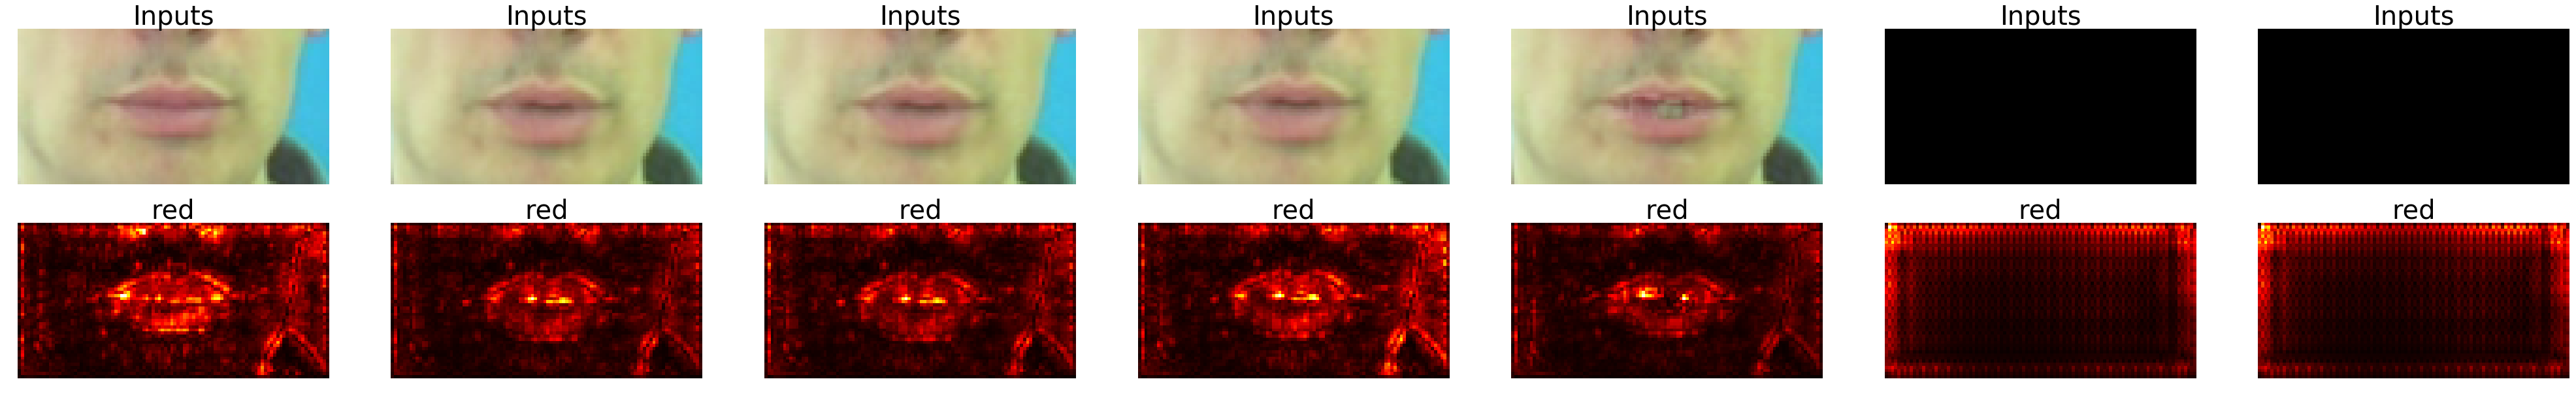

In [50]:
plt.figure(figsize=(70,10))

for i in range(7):
    show_image(mask[i], grayscale = True, ax=plt.subplot(2,7,8+i),
               title=le.inverse_transform(pred_label))
    show_image(x_test[ind][i],grayscale = False, ax=plt.subplot(2,7,1+i), title='Inputs')
plt.savefig('saliency_map.png', dpi=300)
    #show_image(least_mask[i], ax=plt.subplot(6,7,8+i), title='GuidedBackprop')
# for i in range(7):
#     show_image(mask_saliency[i],grayscale = True, ax=plt.subplot(4,7,15+i), title='GradientSaliency')
#     #show_image(least_mask_saliency[i], ax=plt.subplot(6,7,22+i), title='GradientSaliency')
# for i in range(7):
#     show_image(mask_integrated[i], grayscale = True, ax=plt.subplot(4,7,22+i), title='IntegratedGradients')
#     #show_image(least_mask_integrated[i], ax=plt.subplot(6,7,36+i), title='IntegratedGradients')

## Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
preds = model.predict(x_test)
y_pred = np.argmax(preds, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_true, y_pred, labels = range(51))

In [59]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('cm.png', dpi=300)
    plt.show()

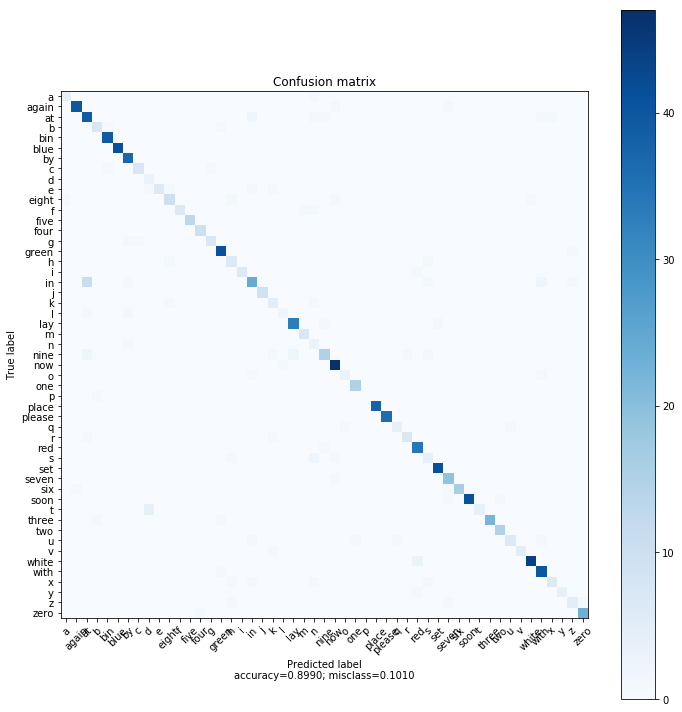

In [60]:
import pickle
with open('le.p', 'rb') as handle:
    le = pickle.load(handle)
plot_confusion_matrix(cm = cm, target_names = list(le.classes_), title='Confusion matrix',
                          normalize=True)

## class visualization

In [85]:
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
def stop_criterion(dx, learning_rate):
    if np.abs(np.min(dx))*learning_rate < 0.01 and np.abs(np.max(dx))*learning_rate < 0.01:
        return True
    else:
        return False
def class_visualization(target_y, model, **kwargs):
    l2_reg = 1e-3
    learning_rate = 100
    num_iterations = 100
    show_every = 10
    D,H,W,C = sil_img.shape
    X = sil_img.astype(float) + np.random.rand(D,H,W,C)*10
    loss = model.output[0][target_y] - l2_reg * tf.nn.l2_loss(model.input)
    gradients = model.optimizer.get_gradients(loss, model.input)
    compute_gradients = K.function(inputs=[model.input,K.learning_phase()], outputs=gradients)
    for frame in range(7):
        show_image(x_test[ind][frame],grayscale = False, ax=plt.subplot(2,7,frame+1), title='Test Image')
    for t in range(num_iterations):
        dx = compute_gradients([np.expand_dims(X, axis=0),0])[0][0]
        loss_np = K.function(inputs=[model.input,K.learning_phase()], outputs=[loss,K.learning_phase()])
        loss_np = loss_np([np.expand_dims(X, axis=0),0])[0]
#         print np.min(dx),'and', np.max(dx)
#         print loss_np
        X += learning_rate * dx
        if loss_np > -10:
            learning_rate = 10
        if stop_criterion(dx, learning_rate) == True:
            for frame in range(7):
                show_image(X[frame],grayscale = False, ax=plt.subplot(2,7,8+frame)
                           , title=le.inverse_transform(pred_label))
    for frame in range(7):
        show_image(X[frame],grayscale = False, ax=plt.subplot(2,7,8+frame)
                   , title=le.inverse_transform(pred_label))

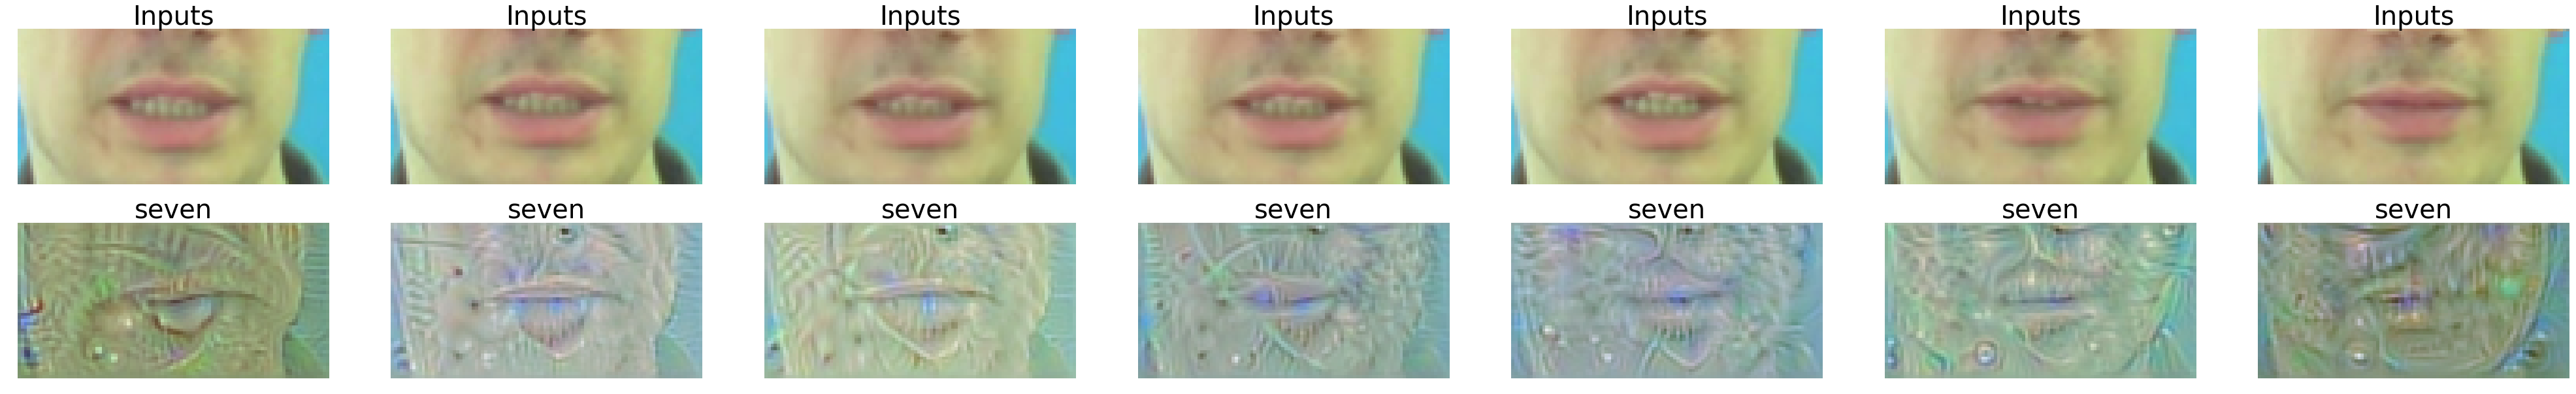

In [91]:
plt.figure(figsize=(70,10))
class_visualization(ind, model)